#Libraries

In [2]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
palette = 'husl'
sns.set_palette(palette)
from scipy.optimize import minimize
import logging

!pip install keras-tuner -q
import keras_tuner

import pandas_datareader.data as web # for FRED data
from datetime import datetime, date
import holidays
from scipy.optimize import Bounds, LinearConstraint
import warnings

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [3]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, MultiHeadAttention, LayerNormalization, Input, Softmax, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.activations import elu
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import StandardScaler
import logging

import pandas_datareader.data as web # for FRED data
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Data + Preprocessing

In [4]:
# Set constants
TIME_STEP= 50
START_DATE = '2006-12-31'
END_DATE = '2023-12-29'
TICKERS = ['DBC', 'AGG', 'VTI', 'VNQ', 'FXE'] # Add more assets, model 1 talks about stock selection
FRED_TICKERS_DICT = {
    'DCOILWTICO': 'wti',  # https://fred.stlouisfed.org/series/DCOILWTICO/
    'T5YIE': 'inflation5y',  # https://fred.stlouisfed.org/series/T5YIE
    'DGS10': 'treasury10y',  # https://fred.stlouisfed.org/series/DGS10
    'VIXCLS': 'vix',  # https://fred.stlouisfed.org/series/VIXCLS/
    'BAMLH0A0HYM2': 'credit_spreads',  # https://fred.stlouisfed.org/series/BAMLH0A0HYM2/
    'FEDFUNDS': 'fedfunds' # Monthly, will be filled forward https://fred.stlouisfed.org/series/fedfunds
}
TRAIN_TEST_SPLIT = 0.80

In [5]:
class Preprocessing:
    def __init__(self, tickers: list = TICKERS, time_step: int = 30,
                 start_date: str = START_DATE, end_date: str = END_DATE,
                 train_test_split: float = 0.8,
                 return_horizon: int = 1,  # 1-day returns
                 asset_features: list = ['Close', 'Volume'],
                 features_in_returns: list = ['wti'] + [t+'_Close' for t in TICKERS] + [t+'_Volume' for t in TICKERS],
                 features_in_level_diffs: list = ['inflation5y', 'treasury10y', 'vix', 'credit_spreads'],
                 target_col: str = 'Close',
                 add_external_data: bool = True,
                 keep_weekly_only: bool = False,
                 explanatory_tickers: dict = FRED_TICKERS_DICT):
        self.tickers = tickers
        self.time_step = time_step
        self.start_date = start_date
        self.end_date = end_date
        self.train_test_split = train_test_split
        self.add_external_data = add_external_data
        self.keep_weekly_only = keep_weekly_only
        self.raw_history = {}
        self.return_horizon = return_horizon
        self.asset_features = asset_features
        self.features_in_returns = features_in_returns
        self.features_in_level_diffs = features_in_level_diffs
        self.target_col = target_col
        self.explanatory_tickers = explanatory_tickers

        self.history_train_df = pd.DataFrame()
        self.history_test_df = pd.DataFrame()
        self.risk_free_train = pd.DataFrame()
        self.risk_free_test = pd.DataFrame()
        self.x_train = np.array([])
        self.y_train = np.array([])
        self.x_scaler_train = None
        self.y_scaler_train = None
        self.x_test = np.array([])
        self.y_test = np.array([])
        self.x_scaler_test = None
        self.y_scaler_test = None

    def _import_data(self):
        logging.info('Importing data from Yahoo...')
        self.raw_history = {ticker: yf.Ticker(ticker).history(start=self.start_date, end=self.end_date)
                            for ticker in self.tickers}

    def import_fred_data(self):
        """
        Import economic data from FRED.
        Remove weekends and holidays. Forward fill NAs, useful for instance
        with FedFunds available monthly
        """
        start = datetime.strptime(START_DATE, '%Y-%m-%d')
        end = datetime.strptime(END_DATE, '%Y-%m-%d')
        external_data = web.DataReader(list(self.explanatory_tickers.keys()), "fred", start, end)
        external_data = external_data.rename(columns=self.explanatory_tickers)

        us_holidays = holidays.UnitedStates()
        holiday_filter = [dt not in us_holidays for dt in external_data.index.date]
        external_data = external_data[(external_data.index.weekday < 5)&(holiday_filter)]
        external_data = external_data.fillna(method='ffill').dropna()

        for col in external_data.columns.values:
            if any(x in col for x in self.features_in_returns):
                external_data[col] = np.log(external_data[col]) - np.log(external_data[col].shift(
                    self.return_horizon))
            if any(x in col for x in self.features_in_level_diffs):
                external_data[col] = external_data[col] - external_data[col].shift(
                    self.return_horizon)

        return external_data

    def _preprocess_data(self, history_data, tickers):
        """
        Place all the input data into one data frame. Add log returns
        where the field should be defined in returns. Fill in nulls.
        """
        feat_df = []
        for ticker in tickers:
            ticker_df = history_data[ticker][self.asset_features].copy()
            names_dict = dict(zip(self.asset_features, [f'{ticker}_{ft}' for ft in self.asset_features]))
            ticker_df.rename(columns=names_dict, inplace=True)
            feat_df.append(ticker_df)

        feat_df = pd.concat(feat_df, axis=1)
        feat_df = feat_df.fillna(method='ffill')

        feat_df_incl_ret = feat_df.copy()

        for col in feat_df.columns.values:
            if any(x in col for x in self.features_in_returns) and any(x not in col for x in self.features_in_level_diffs):
                feat_df_incl_ret[col] = np.log(feat_df_incl_ret[col]) - np.log(feat_df_incl_ret[col].shift(
                    self.return_horizon))
            elif any(x in col for x in self.features_in_level_diffs):
                feat_df_incl_ret[col] = feat_df_incl_ret[col] - feat_df_incl_ret[col].shift(
                    self.return_horizon)

        feat_df_incl_ret.dropna(inplace=True)

        feat_df_incl_ret.reset_index(drop=False, inplace=True)
        feat_df_incl_ret['Date'] = pd.to_datetime(feat_df_incl_ret['Date']).dt.date
        feat_df_incl_ret.set_index('Date', inplace=True)

        return feat_df_incl_ret

    def create_x_y_sequences(self, data_df, lookback):
        """
        Creates input sequences for a time series data with a specified lookback window.
        Assumes that y (target) is one of the columns in data_df.
        Transform the data into sequence of lookback length to predict one step forward (y).
        """
        sequences = []
        targets = []
        target_cols = [col for col in data_df.columns.values if self.target_col in col]

        y_data = data_df[target_cols].values
        x_data = data_df.values

        x_scaler = MinMaxScaler(feature_range=(0, 1))
        y_scaler = MinMaxScaler(feature_range=(0, 1))

        x_data = x_scaler.fit_transform(x_data)
        y_data = y_scaler.fit_transform(y_data)

        for i in range(len(data_df) - lookback):
            x_sequence = x_data[i: i + lookback]
            y_target = y_data[i + lookback]
            sequences.append(x_sequence)
            targets.append(y_target)

        return np.array(sequences), np.array(targets), x_scaler, y_scaler

    def run(self):
        """
        Source data if it has not been sourced.
        Split the data into train and test, and standardise.
        Clean and prepare data in the sequence format needed for modelling.
        """
        history_train = {}
        history_test = {}

        if len(self.raw_history) == 0:
            self._import_data()

        # Train Test split
        for ticker, data in self.raw_history.items():
            train_size = int(len(data) * self.train_test_split)
            history_train[ticker], history_test[ticker] = data[:train_size], data[train_size:]

        history_train_clean = self._preprocess_data(history_train, self.tickers)
        history_test_clean = self._preprocess_data(history_test, self.tickers)

        self.history_train_df = history_train_clean
        self.history_test_df = history_test_clean

        # Join with FRED macro data
        if self.add_external_data:
            fred_df = self.import_fred_data()
            self.history_test_df = self.history_test_df.join(fred_df, how='inner').fillna(method='ffill').dropna()
            self.history_train_df = self.history_train_df.join(fred_df, how='inner').fillna(method='ffill').dropna()

            self.risk_free_train = pd.DataFrame(self.history_train_df['fedfunds'][self.time_step:])
            self.risk_free_test = pd.DataFrame(self.history_test_df['fedfunds'][self.time_step:])

        if self.keep_weekly_only:
            self.history_test_df = self.history_test_df[(self.history_test_df.index.weekday == 4)]
            self.history_train_df = self.history_train_df[(self.history_train_df.index.weekday == 4)]

            if self.add_external_data:
              self.risk_free_train = self.risk_free_train[(self.risk_free_train.index.weekday == 4)]
              self.risk_free_test = self.risk_free_test[(self.risk_free_test.index.weekday == 4)]
        # Prepare modelling sequences of train and test
        self.x_train, self.y_train, self.x_scaler_train, self.y_scaler_train = self.create_x_y_sequences(
            self.history_train_df, self.time_step)
        self.x_test, self.y_test, self.x_scaler_test, self.y_scaler_test = self.create_x_y_sequences(
            self.history_test_df, self.time_step)

        data_struct = {
            'x_train': self.x_train,
            'y_train': self.y_train,
            'x_test': self.x_test,
            'y_test': self.y_test,

            'x_scaler_train': self.x_scaler_train,
            'y_scaler_train': self.y_scaler_train,
            'x_scaler_test': self.x_scaler_test,
            'y_scaler_test': self.y_scaler_test
        }
        return data_struct


In [6]:
pp = Preprocessing(
    time_step=TIME_STEP,
    tickers=TICKERS,
    add_external_data=True,
    keep_weekly_only=True,
    explanatory_tickers=FRED_TICKERS_DICT,
    asset_features=['Close'],
    features_in_returns=['wti'] + [t+'_Close' for t in TICKERS] + [t+'_Volume' for t in TICKERS],
    features_in_level_diffs=['inflation5y', 'treasury10y', 'vix', 'credit_spreads'], #'AGG_Close'
    return_horizon=5)
data = pp.run()

X_train= data['x_train']
Y_train = data['y_train']
X_test = data['x_test']
Y_test = data['y_test']

X_scaler_train = data['x_scaler_train']
y_scaler_train = data['y_scaler_train']
X_scaler_test = data['x_scaler_test']
y_scaler_test = data['y_scaler_test']

history_train_clean = pp.history_train_df
history_test_clean= pp.history_test_df

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
X_train.shape

(626, 50, 11)

In [7]:
Y_train.shape

(626, 5)

In [8]:
history_test_clean.shape

(166, 11)

# Time2Vec

## **Time Embeddings**
The Time2Vec layer is a crucial component in sequence modeling, especially for time-series data, as it provides a rich representation of temporal information. By embedding time into a continuous vector space, Time2Vec enables neural networks to effectively capture both the linear progression and periodic patterns inherent in time-series data. This not only enhances the model's understanding of temporal dependencies but also facilitates better generalization and performance in downstream tasks, such as forecasting, classification, and anomaly detection.


1. **Linear Component:**
   - The linear component represents the linear progression of time. It is calculated as:
     ```
     Linear Component = linear_weight * t
     ```
   - Where:
     - \( t \) is the input time step.
     - `linear_weight` is the learnable parameter controlling the linear progression.

2. **Sinusoidal Components:**
   - The sinusoidal components capture periodic patterns in the data. Each sinusoidal component is calculated as:
     ```
     Sinusoidal Component_i = sin(2π * t / sinusoidal_weights_i)
     ```
   - Where:
     - \( i \) ranges from 0 to `kernel_size - 2`, corresponding to the number of sinusoidal components.
     - `sinusoidal_weights_i` are the learnable parameters controlling the frequency of the \( i \)th sinusoidal component.

3. **Combined Representation:**
   - The Time2Vec output is obtained by summing the linear component and all sinusoidal components:
     ```
     Time2Vec Output = Linear Component + Σ Sinusoidal Component_i
     ```
   - This combined representation captures both the linear progression and periodic patterns in the data.

In [ ]:
class Time2Vec(Layer):
    def __init__(self, kernel_size, num_features, scale=1.0):
        super(Time2Vec, self).__init__()
        self.kernel_size = kernel_size
        self.num_features = num_features
        self.scale = scale  # A scale factor for the output of the sinusoidal part

    def build(self, input_shape):
        # Initialize linear weight with a larger range, e.g., (-scale, scale)
        self.linear_weight = self.add_weight(
            name='linear_weight',
            shape=(self.num_features,),
            initializer=tf.initializers.RandomUniform(minval=-self.scale, maxval=self.scale),
            trainable=True
        )
        # Bias might not need scaling if you want it to start centered
        self.linear_bias = self.add_weight(
            name='linear_bias',
            shape=(self.num_features,),
            initializer='zeros',
            trainable=True
        )
        # Initialize sinusoidal weights with a larger range to encourage varied outputs
        self.sinusoidal_weights = self.add_weight(
            name='sinusoidal_weights',
            shape=(self.kernel_size - 1, self.num_features),
            initializer=tf.initializers.RandomUniform(minval=-self.scale, maxval=self.scale),
            trainable=True
        )

    def call(self, inputs):
        # Scale inputs for the linear part to match the expected range
        linear_part = (self.linear_weight * inputs + self.linear_bias) * self.scale

        # List to store sinusoidal transformations, scaled by the factor
        sin_parts = [tf.sin(inputs * self.sinusoidal_weights[i]) * self.scale for i in range(self.kernel_size - 1)]

        # Concatenate all parts and scale the sinusoidal output
        return tf.concat([tf.expand_dims(linear_part, -1)] + [tf.expand_dims(part, -1) for part in sin_parts], axis=-1)


   # def compute_output_shape(self, input_shape):
    #    return (input_shape[0], input_shape[1], self.kernel_size)



#print("Fixed!")


# Causal Attention mask

In [ ]:

# Causal attention mask function
def create_causal_attention_mask(seq_len):
    mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    mask = mask[tf.newaxis, tf.newaxis, :, :]  # Add batch and head dimensions
    return tf.cast(mask, tf.float32)


def create_sequences_with_targets(data, sequence_length, num_assets):
    input_sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        input_sequences.append(data[i:i+sequence_length])
        targets.append(data[i+sequence_length])  # The paper's target is the next day's return
    return np.array(input_sequences), np.array(targets)

# Modified custom Loss


---

### Optimization of Investment Portfolios Using a Modified Sharpe Ratio Loss Function
This function integrates risk-adjusted return, diversification, and smooth transition penalties to guide the allocation of assets within a portfolio.

the modified Sharpe ratio loss function aims to maximize the Sharpe ratio, denoted as \( S \). The Sharpe ratio represents the ratio of the expected excess return of a portfolio to its standard deviation of returns:

$S = \frac{{\text{Mean_return}}}{{\text{Portfolio Standard Deviation}}}$

The function seeks to maximize this ratio to achieve an optimal balance between portfolio returns and risks.

#### **Diversification Penalty**

Diversification is promoted through a penalty term that discourages excessive concentration of investments. The penalty term, denoted as \( D \), is calculated as the average standard deviation of allocations across different assets:

$D = \frac{1}{N} \sum_{i=1}^{N} \sigma_i$

where $N$ is the number of assets in the portfolio, and \( \sigma_i \) is the standard deviation of allocation for asset \( i \).

#### **Smooth Transition Penalty**

To minimize portfolio turnover and transaction costs, the function penalizes abrupt changes in asset allocations. The smooth transition penalty, denoted as $T$, is calculated as the average absolute difference between adjacent allocations:

$T = \frac{1}{N-1} \sum_{i=1}^{N-1} |a_{i+1} - a_i|$

where $a_i$ represents the allocation to asset $i$.


The function offers customization through regularization parameters  $\lambda_{{div}}$ and  $lambda_{{shift}}$. These parameters allow investors to balance the objectives of maximizing the Sharpe ratio while controlling diversification and transition penalties.

The final loss function \( L \) is expressed as:

$L = -S + \lambda_{\text{div}} \cdot D + \lambda_{\text{shift}} \cdot T$


In summary, the modified Sharpe ratio loss function provides a mathematical framework for optimizing investment portfolios. By maximizing the Sharpe ratio while penalizing excessive concentration and abrupt transitions, the function enables investors to construct portfolios that strike a balance between risk and return while adhering to diversification and transition constraints.

---


In [ ]:

def modified_sharpe_ratio_loss(y_true_scaled_log, y_pred):
    """
    Modified Sharpe ratio loss function that reverses the scaling of the returns and
    then computes the Sharpe ratio based on the unscaled returns and predicted weights.

    Args:
    - y_true_scaled_log: The true scaled log returns.
    - y_pred: The predicted allocation weights by the model.
    - y_test_scaler_min: The minimum value (min_) from the original MinMaxScaler.
    - y_test_scaler_scale: The scale value (scale_) from the original MinMaxScaler.

    Returns:
    - A scalar loss value representing the negative Sharpe ratio adjusted with penalties.
    """




    y_scaler_min = y_scaler_train.data_min_
    y_scaler_max = y_scaler_train.data_max_

    # Reverse the scaling using the explicit data min and max
    y_true_unscaled = (y_true_scaled_log * (y_scaler_max - y_scaler_min)) + y_scaler_min
    y_true_unscaled = tf.exp(y_true_unscaled) - 1

    # Portfolio returns for each sample
    y_pred_normalized = y_pred / tf.reduce_sum(y_pred, axis=1, keepdims=True)

    portfolio_returns = tf.reduce_sum(y_pred_normalized * y_true_unscaled, axis=1)
    mean_return = tf.reduce_mean(portfolio_returns)
    std_dev = tf.math.reduce_std(portfolio_returns)
    std_dev = tf.where(tf.equal(std_dev, 0), 1e-6, std_dev)  # Avoid division by zero

    # Sharpe ratio as the ratio of mean return to standard deviation
    sharpe_ratio = mean_return / std_dev

    # Penalty for lack of diversification (standard deviation across the predicted weights)
    diversification_penalty = tf.reduce_mean(tf.math.reduce_std(y_pred, axis=-1))

    # Penalty for large shifts in allocation weights between adjacent time steps
    shift_penalty = tf.reduce_mean(tf.abs(y_pred[:, 1:] - y_pred[:, :-1]))
    lambda_div = 0.7
    lambda_shift = 0.05


    final_loss = -sharpe_ratio + lambda_div * diversification_penalty + lambda_shift * shift_penalty

    return final_loss


#Train

In [ ]:
Y_train.shape


(626, 5)

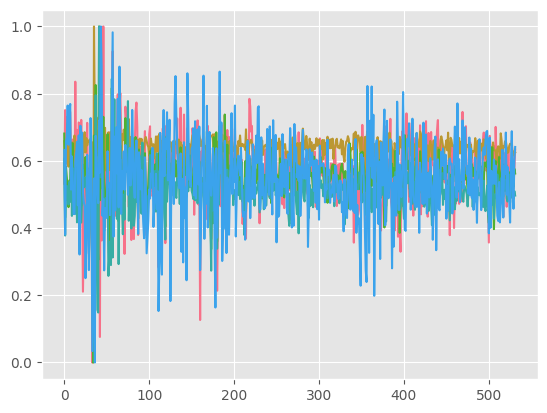

In [8]:
batch_size = 8
# Split into training and validation sets
train_size = int(0.85 * len(X_train))  # Adjusted to use 85% for training based on your setup
x_train, y_train = X_train[:train_size], Y_train[:train_size]
x_val, y_val = X_train[train_size:], Y_train[train_size:]
plt.plot(y_train)
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
x_test, y_test = X_test, Y_test[:train_size]
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)


In [ ]:

def plot_portfolio_weights(weights):
  """
  Plot portfolio weights. USes constants defined top of this notebook as labels
  """
  fig, ax = plt.subplots(figsize=(10, 6))
  bottom = np.zeros(weights.shape[0])

  for i in range(weights.shape[1]):
      ax.bar(range(weights.shape[0]), weights[:, i], label=TICKERS[i], bottom=bottom)
      bottom += weights[:, i]

  ax.set_xlabel('Time')
  ax.set_ylabel('Weights')
  ax.set_title('Portfolio Weights Over Time')
  ax.legend()
  ax.grid(True)
  plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Layer, Dense, Input, Dropout, Softmax, Lambda, MultiHeadAttention, LayerNormalization, Concatenate, Reshape, ELU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

class GatedResidualNetwork(Layer):
    def __init__(self, d_model, **kwargs):
        super(GatedResidualNetwork, self).__init__(**kwargs)
        self.d_model = d_model
        self.W2 = Dense(d_model * 2)  # W2 layer that outputs 2*d_model dimensions for GLU
        self.W1 = Dense(d_model)
        self.layer_norm = LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        g2 = self.W2(inputs)
        g2 = ELU()(g2)
        u, v = tf.split(g2, 2, axis=-1)
        gated_g2 = u * tf.sigmoid(v)
        g1 = self.W1(gated_g2)
        return self.layer_norm(inputs + g1)

# considered as enhancement to referenced paper
class FeedForwardNetwork(Layer):
    def __init__(self, d_model, dff=256, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.dense1 = Dense(dff, activation='relu')  # dff is the dimensionality of the feed-forward layer
        self.dense2 = Dense(d_model)
        self.dropout = Dropout(rate)

    def call(self, x):
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return x


class PortfolioTransformer(Model):
    def __init__(self, num_assets, d_model, num_heads, encoder_stack, decoder_stack, time2vec_dim, softmax_temperature=0.6, **kwargs):
        super(PortfolioTransformer, self).__init__(**kwargs)
        self.reshape_layer = Reshape((-1, d_model))  # Adjusted reshaping layer

        # Time2Vec Embedding
        self.time2vec_embedding = Time2Vec(time2vec_dim, num_features=num_assets)
        self.time2vec_to_dmodel = Dense(d_model)
        self.softmax_temperature = softmax_temperature

        # Encoder and Decoder layers
        self.encoder_layers = [self._build_encoder_layer(d_model, num_heads) for _ in range(encoder_stack)]
        self.decoder_layers = [self._build_decoder_layer(d_model, num_heads) for _ in range(decoder_stack)]

        self.final_linear = Dense(5)
        self.softmax = Softmax()
        self.sign = Lambda(lambda x: tf.sign(x))

    def call(self, inputs):
        time_embeddings = self.time2vec_embedding(inputs)
        transformed_time_embeddings = self.time2vec_to_dmodel(time_embeddings)
        reshaped_input = self.reshape_layer(transformed_time_embeddings)

        # Encoder stack
        encoder_output = reshaped_input
        for enc_layer in self.encoder_layers:
            encoder_output = enc_layer(encoder_output)

        # Decoder stack
        decoder_output = encoder_output
        for dec_layer in self.decoder_layers:
            decoder_output = dec_layer([decoder_output, reshaped_input])  # Pass original input to decoder layers

        # Output layer computation
        logits = self.final_linear(decoder_output) / self.softmax_temperature
        output = self.softmax(logits)
        output = self.sign(output) * output
        output = output[:, -1, :]

        return output

    def _build_encoder_layer(self, d_model, num_heads):
        inputs = Input(shape=(None, d_model))
        attention_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
        attention_out = Dropout(0.1)(attention_out)  # Dropout for regularization

        grn_out = GatedResidualNetwork(d_model)(attention_out + inputs)  # Concatenate inputs and attention output
        ffn = FeedForwardNetwork(d_model, dff=128, rate=0.1)(grn_out)
        output = LayerNormalization(epsilon=1e-6)(ffn + grn_out)
        #add_norm_out = LayerNormalization(epsilon=1e-6)(grn_out)
        return Model(inputs=inputs, outputs=output)

    def _build_decoder_layer(self, d_model, num_heads):
        decoder_input = Input(shape=(None, d_model))
        encoder_output = Input(shape=(None, d_model))

        # First Multi-Head Attention Layer (Masked)
        self_attention_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(
            query=decoder_input,
            value=decoder_input,
            attention_mask=create_causal_attention_mask(tf.shape(decoder_input)[1])
        )
        self_attention_out = Dropout(0.1)(self_attention_out)  # Dropout for regularization

        # Add a Dense layer to transform encoder_output shape to d_model
        encoder_output_transformed = Dense(d_model)(encoder_output)

        # Second Multi-Head Attention Layer (Enc-Dec Attention)
        attention_out = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(
            query=self_attention_out,
            value=encoder_output_transformed
            # No mask here as we want full attention with the encoder outputs
        )
        attention_out = Dropout(0.1)(attention_out)  # Dropout for regularization

        # Gated Residual Network (GRN)
        grn_out = GatedResidualNetwork(d_model)(attention_out)  # Pass attention output to GRN
        add_norm_out = LayerNormalization(epsilon=1e-6)(grn_out)

        # Return a Model
        return Model(inputs=[decoder_input, encoder_output], outputs=add_norm_out)


# Compile the model
model = PortfolioTransformer(num_assets=11, d_model=16, num_heads=3, encoder_stack=3, decoder_stack=3, time2vec_dim=32, softmax_temperature=1)
model.compile(optimizer=Adam(), loss=modified_sharpe_ratio_loss)

# Fit the model
history = model.fit(train_dataset, epochs=300, validation_data=val_dataset) #, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# Further predictions and plotting
# Assuming you have test data in test_dataset
predictions = model.predict(train_dataset)

# Inverse transform predictions if necessary
# Plot portfolio weights
#plot_portfolio_weights(predictions)


Epoch 1/300
67/67 [==============================] - 51s 93ms/step - loss: -0.0791 - val_loss: -0.0529
Epoch 2/300
67/67 [==============================] - 5s 72ms/step - loss: -0.0242 - val_loss: -0.0712
Epoch 3/300
67/67 [==============================] - 4s 65ms/step - loss: -0.0469 - val_loss: -0.1080
Epoch 4/300
67/67 [==============================] - 4s 65ms/step - loss: -0.0812 - val_loss: -0.1703
Epoch 5/300
67/67 [==============================] - 5s 72ms/step - loss: -0.0929 - val_loss: -0.1843
Epoch 6/300
67/67 [==============================] - 4s 64ms/step - loss: -0.1168 - val_loss: -0.1758
Epoch 7/300
67/67 [==============================] - 5s 73ms/step - loss: -0.1221 - val_loss: -0.1836
Epoch 8/300
67/67 [==============================] - 4s 65ms/step - loss: -0.1155 - val_loss: -0.1747
Epoch 9/300
67/67 [==============================] - 4s 65ms/step - loss: -0.1001 - val_loss: -0.1893
Epoch 10/300
67/67 [==============================] - 5s 73ms/step - loss: -0.104

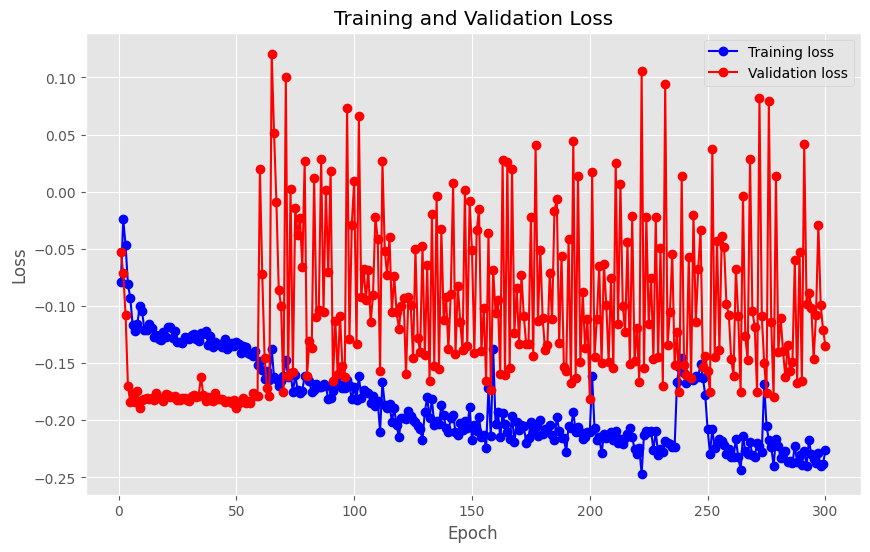

In [ ]:
import matplotlib.pyplot as plt

loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, 'bo-', label='Training loss')
plt.plot(epochs, val_loss_values, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Portfolio Allocations

4/4 [==============================] - 2s 74ms/step


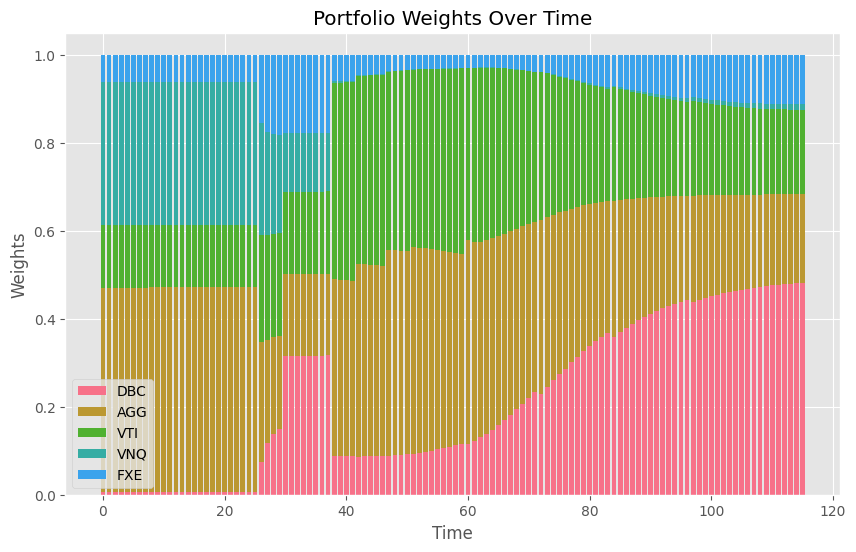

In [ ]:

# Further predictions and plotting
# Assuming you have test data in test_dataset
predictions_test = model.predict(X_test)

# Inverse transform predictions if necessary
# Plot portfolio weights
plot_portfolio_weights(predictions_test)


20/20 [==============================] - 1s 68ms/step


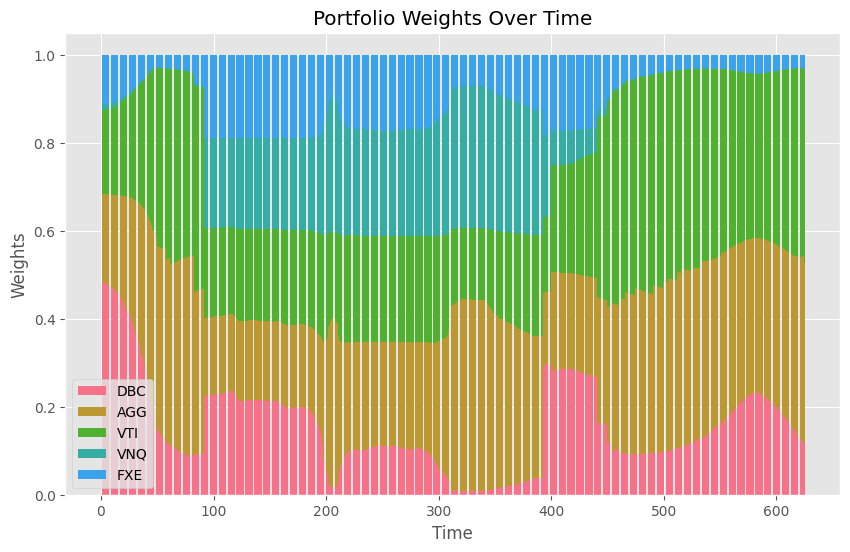

In [ ]:
predictions_train = model.predict(X_train)

# Inverse transform predictions if necessary
# Plot portfolio weights
plot_portfolio_weights(predictions_train)

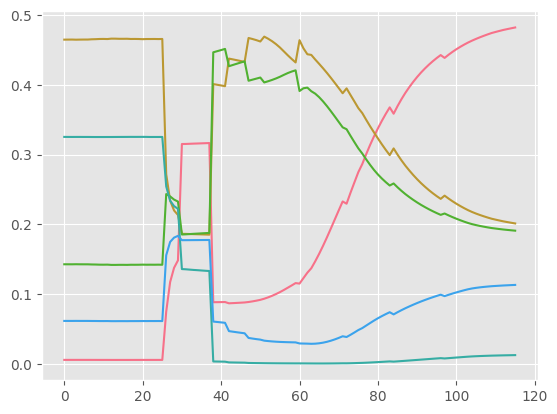

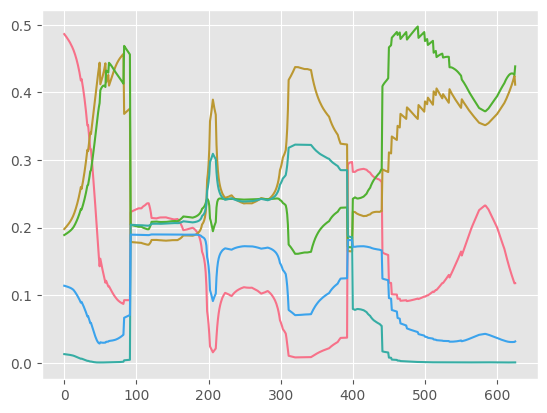

In [ ]:
plt.plot(predictions_test)
plt.show()
plt.plot( predictions_train)
plt.show()

In [ ]:
y_test_scaled = y_scaler_test.inverse_transform(Y_test)
y_train_scaled = y_scaler_train.inverse_transform(Y_train)



In [ ]:

def calculate_and_plot_returns(returns_data, weights1, weights2,
                               label1='Model1 Strategy', label2='Equal Weights',
                               plot_title='Test returns'):
  portfolio_log_returns = (weights1 * returns_data[MARKOWITZ_TIME_WINDOW:]).sum(axis=1)
  portfolio_log_returns2 = (weights2 * returns_data[MARKOWITZ_TIME_WINDOW:]).sum(axis=1)

  # Cumulative log returns
  cumulative_portfolio_log_return = np.cumsum(portfolio_log_returns)
  cumulative_portfolio_log_return2 = np.cumsum(portfolio_log_returns2)

  # Normal returns?
  cumulative_portfolio_return = np.exp(cumulative_portfolio_log_return) - 1
  cumulative_portfolio_return2 = np.exp(cumulative_portfolio_log_return2) - 1

  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
  ax1.plot(cumulative_portfolio_log_return, label=label1)
  ax1.plot(cumulative_portfolio_log_return2, label=label2)
  ax1.set_title('Cumulative log returns')
  ax1.set_ylabel('Cumulative log returns')
  ax1.set_xlabel('Time')
  ax1.legend(loc='upper right')

  ax2.plot(cumulative_portfolio_return, label=label1)
  ax2.plot(cumulative_portfolio_return2, label=label2)
  ax2.set_title('Cumulative returns')
  ax2.set_ylabel('Cumulative returns')
  ax2.set_xlabel('Time')
  ax2.legend(loc='upper right')
  f.suptitle(plot_title)

In [ ]:
MARKOWITZ_TIME_WINDOW = 5
equal_weights_test = np.array([np.repeat(1/len(TICKERS), len(TICKERS)) for _ in
                               range(y_test_scaled[MARKOWITZ_TIME_WINDOW:].shape[0])])


In [ ]:
MARKOWITZ_TIME_WINDOW = 5
equal_weights_train = np.array([np.repeat(1/len(TICKERS), len(TICKERS)) for _ in
                               range(y_train_scaled[MARKOWITZ_TIME_WINDOW:].shape[0])])


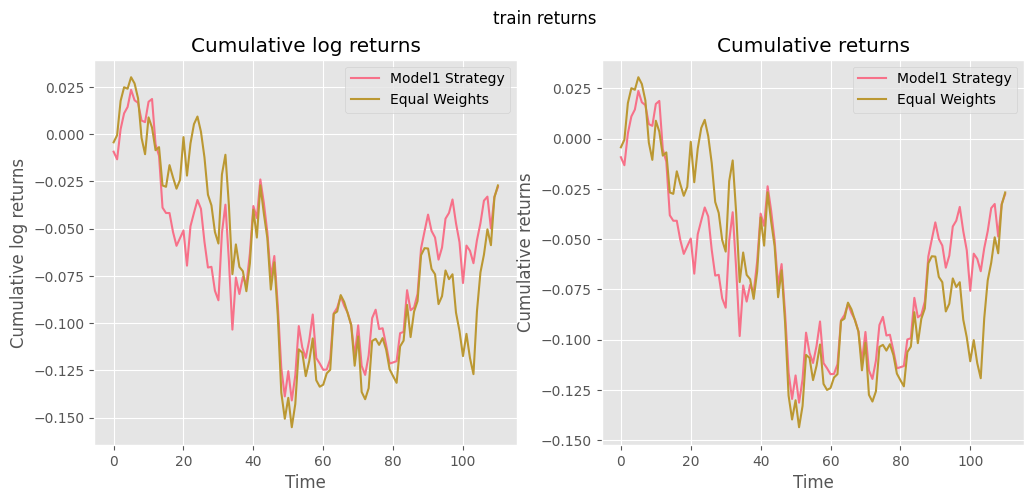

In [ ]:
calculate_and_plot_returns(y_test_scaled, predictions_test[MARKOWITZ_TIME_WINDOW:], equal_weights_test, plot_title='train returns')

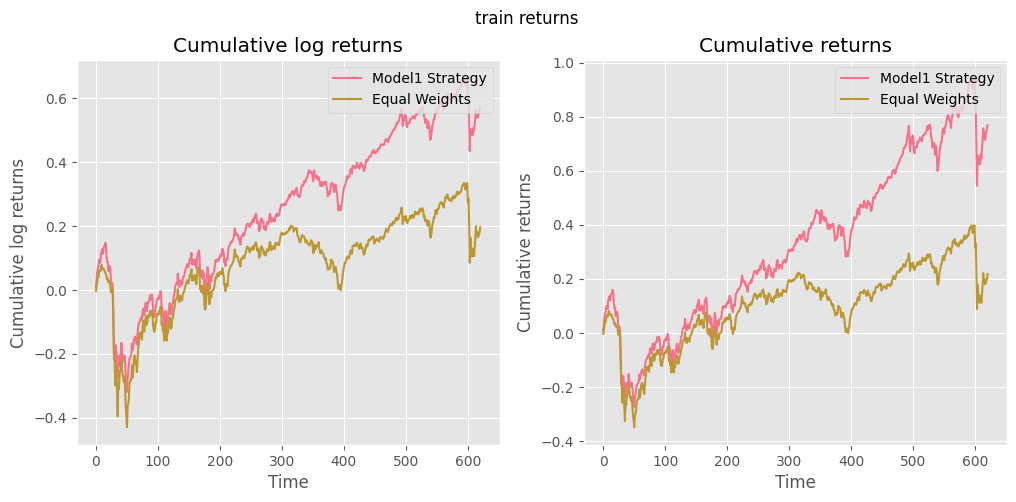

In [ ]:
calculate_and_plot_returns(y_train_scaled, predictions_train[MARKOWITZ_TIME_WINDOW:], equal_weights_train, plot_title='train returns')

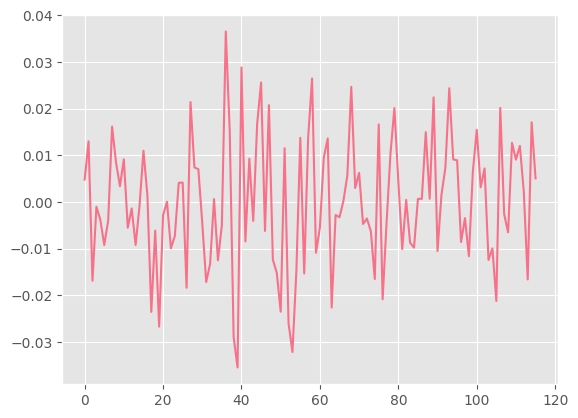

In [ ]:
plt.plot(np.sum((np.exp(y_test_scaled)-1)*predictions_test, axis=1))

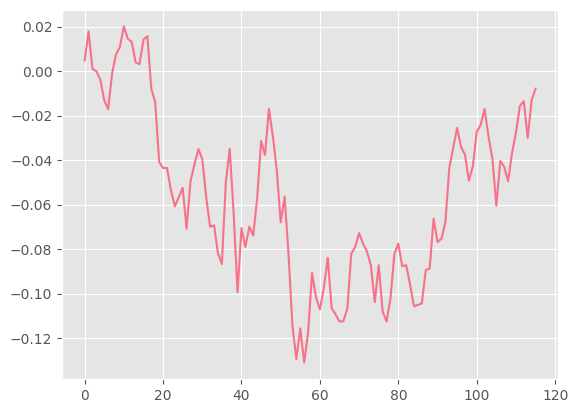

In [ ]:
plt.plot(np.sum(np.cumsum((np.exp(y_test_scaled)-1)*predictions_test, axis=0), axis=1))

In [ ]:
returns_test = (np.sum((np.exp(y_test_scaled)-1)*predictions_test, axis=1))

In [ ]:
returns_train = (np.sum((np.exp(y_train_scaled)-1)*predictions_train, axis=1))

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
import os

# Assuming 'history_test_clean' is a pandas DataFrame and 'predictions_test' is a numpy array or a pandas Series
# Compute the returns
#returns_test = history_test_clean[30:] * predictions_test

# Convert to a DataFrame
returns_test_df = pd.DataFrame(returns_test)
preds_test = pd.DataFrame(predictions_test)
preds_train = pd.DataFrame(predictions_train)
returns_train_df = pd.DataFrame(returns_train)

# Save to CSV file
returns_test_df.to_csv('/content/drive/My Drive/returns_test.csv', index=False)
returns_train_df.to_csv('/content/drive/My Drive/returns_train.csv', index=False)

preds_test.to_csv('/content/drive/My Drive/preds_test.csv', index=False)
preds_train.to_csv('/content/drive/My Drive/preds_train.csv', index=False)

Mounted at /content/drive


In [ ]:
model

In [ ]:
model.save_weights('path_to_my_weights.ckpt')


In [ ]:
# Assuming 'PortfolioTransformer' is the class of your model

# First, recreate the model (make sure it's the same architecture)
model2 = PortfolioTransformer(num_assets=11, d_model=16, num_heads=3, encoder_stack=3, decoder_stack=3, time2vec_dim=32, softmax_temperature=2)

# Then, load the weights
model2.load_weights('path_to_my_weights.ckpt')

In [ ]:
path_to_save_weights = '/content/drive/My Drive/path_to_my_weights.ckpt'

# Save the weights
model.save_weights(path_to_save_weights)

# CVAE

Firstly, approach with conditional variational autoencoder was used to add external data information into the initial dataset. Because of the noise of data, even thoguh when managering it on weekly basis rather than daily, the condition on external data doesn't enrich the overall input for further model, but rather making it more difficult to capture true patterns from returns

For portfolio managers, using a CVAE can aid in dynamic asset allocation by predicting how different asset classes or sectors might perform under various economic conditions.

In [9]:
import requests
import json
import plotly.graph_objects as go

import pandas as pd


In [95]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class CVAE(Model):
    def __init__(self, latent_dim, input_shape):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.concat_layer = layers.Concatenate(axis=1)

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
            #layers.Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer = 'he_normal'),
            layers.Dense(64, activation = 'relu'),
            #layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.Dense(32, activation = 'relu' ), #,  kernel_initializer = 'he_normal'),
            layers.Dense(latent_dim * 2),  # For mean and log variance
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(32, activation = 'relu' ),#,  kernel_initializer = 'he_normal'),
            #layers.Dense(64, activation = 'relu'),
            #layers.Dense(128, activation = 'relu', kernel_initializer = 'he_normal'),
            layers.Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.Dense(input_shape),  # Dynamically set the output size based on input shape
        ])

    def encode(self, x, condition):
        condition = tf.expand_dims(condition, -1)  # Now condition shape is (8, 1)

        #print("Shape of x:", x.shape)
        #print("Shape of condition:", condition.shape)
        concat = self.concat_layer([x, condition])
        #print("Shape after concatenation in encode:", concat.shape)
        encoder_output = self.encoder(concat)
        z_mean, z_log_var = tf.split(encoder_output, num_or_size_splits=2, axis=1)
        #print("Shape of z_mean:", z_mean.shape)
        #print("Shape of z_log_var:", z_log_var.shape)
        return z_mean, z_log_var

    def decode(self, z, condition, apply_sigmoid=False):
        condition = tf.expand_dims(condition, -1)  # Expanding dimensions to make it (batch_size, 1)
        condition = tf.broadcast_to(condition, [tf.shape(z)[0], tf.shape(z)[1]])  # Broadcasting to match dimensions of z


        concat = self.concat_layer([z, condition])
        #print("Shape after concatenation in decode:", concat.shape)
        logits = self.decoder(concat)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

    def reparameterize(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        epsilon = tf.random.normal(shape=(batch, self.latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


    def call(self, x, condition):
        z_mean, z_log_var = self.encode(x, condition)
        z = self.reparameterize(z_mean, z_log_var)
        reconstruction = self.decode(z, condition)
        return reconstruction, z_mean, z_log_var


In [96]:
# NEW
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

def compute_loss(model, x, condition):
    reconstruction, z_mean, z_log_var = model(x, condition)

    # Calculate the reconstruction loss as the mean squared error between the input and reconstruction
    # No need to manually reduce the loss as tf.keras.losses.mean_squared_error already does this when reduction='auto'
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(x, reconstruction))
    #print("Reconstruction loss:", reconstruction_loss.numpy())
    # Calculate the KL divergence
    kl_div = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    #print("KL divergence:", kl_div.numpy())
    # Total loss is the sum of reconstruction loss and KL divergence
    total_loss = reconstruction_loss + kl_div
    #print("Total loss:", total_loss.numpy())
    return total_loss

@tf.function
def train_step(model, x, condition, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, condition)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss



In [13]:
history_train_clean

,DBC_Close,AGG_Close,VTI_Close,VNQ_Close,FXE_Close,wti,inflation5y,treasury10y,vix,credit_spreads,fedfunds
2007-02-09,0.008637,0.003012,-0.004321,0.016016,0.003309,0.014302,-0.05,-0.04,1.02,-0.08,5.26
2007-02-16,0.002862,0.004801,0.012422,-0.001403,0.011002,-0.008051,-0.05,-0.10,-1.08,-0.02,5.26
2007-02-23,0.047464,0.001497,0.000483,-0.021108,0.002276,0.039938,0.11,-0.02,0.36,-0.04,5.26
2007-03-02,-0.017587,0.007497,-0.048480,-0.055247,0.002711,0.021337,-0.01,-0.16,8.03,0.36,5.26
2007-03-09,-0.003636,-0.004181,0.012950,0.011271,-0.005546,-0.024993,0.02,0.07,-4.52,-0.16,5.26
...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,-0.022971,0.001781,-0.028201,-0.040724,0.003309,-0.030418,0.05,-0.06,-0.39,0.39,0.08
2020-07-10,0.015924,0.002535,0.018056,-0.025154,0.005267,-0.000247,0.04,-0.03,-0.39,-0.03,0.09
2020-07-17,0.000000,0.003286,0.013822,0.007015,0.012028,-0.000247,0.10,-0.01,-1.61,-0.40,0.09
2020-07-24,0.018780,0.003359,-0.003069,-0.005992,0.017366,0.016630,0.00,-0.05,0.16,-0.45,0.09


# Conditioning on VIX

In [74]:
ctrain_combined_df_normalized = (history_train_clean - history_train_clean.min()) / (history_train_clean.max() - history_train_clean.min())
returns_log = train_combined_df_normalized.iloc[:,:5]
vix = train_combined_df_normalized['vix']

train_dataseds = train_combined_df_normalized['vix']

train_dataset_cvae = tf.data.Dataset.from_tensor_slices((returns_log.values, vix.values))
train_dataset_cvae = train_dataset_cvae.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

print(train_dataset_cvae)
## Batching the dataset
batch_size = 8  # Adjust based on your requirements
train_dataset_cvae = train_dataset_cvae.batch(batch_size)



<_MapDataset element_spec=(TensorSpec(shape=(5,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [75]:
# Assuming combined_df and daily_interest are correctly prepared and normalized
latent_dim = 6
input_shape = returns_log.shape[1]  # Number of features in your ETF data

# Initialize CVAE model
cvae = CVAE(latent_dim=latent_dim, input_shape=input_shape)

# Training loop
epochs = 50
for epoch in range(epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    for x_batch, condition_batch in train_dataset_cvae:
        #print(x_batch)
        #print(condition_batch)
        loss = train_step(cvae, x_batch, condition_batch, optimizer)
        epoch_loss_avg.update_state(loss)
    print(f'Epoch: {epoch+1}, Loss: {epoch_loss_avg.result().numpy()}')


Epoch: 1, Loss: 0.1677500307559967
Epoch: 2, Loss: 0.029013091698288918
Epoch: 3, Loss: 0.020014695823192596
Epoch: 4, Loss: 0.01910472847521305
Epoch: 5, Loss: 0.017594998702406883
Epoch: 6, Loss: 0.01704464666545391
Epoch: 7, Loss: 0.015885071828961372
Epoch: 8, Loss: 0.015432453714311123
Epoch: 9, Loss: 0.015630805864930153
Epoch: 10, Loss: 0.01494615338742733
Epoch: 11, Loss: 0.014646658673882484
Epoch: 12, Loss: 0.013774912804365158
Epoch: 13, Loss: 0.014337320812046528
Epoch: 14, Loss: 0.01419631578028202
Epoch: 15, Loss: 0.014040544629096985
Epoch: 16, Loss: 0.013163638301193714
Epoch: 17, Loss: 0.013064182363450527
Epoch: 18, Loss: 0.012680776417255402
Epoch: 19, Loss: 0.012585240416228771
Epoch: 20, Loss: 0.012601193971931934
Epoch: 21, Loss: 0.01270985882729292
Epoch: 22, Loss: 0.01228232029825449
Epoch: 23, Loss: 0.011767693795263767
Epoch: 24, Loss: 0.01155999768525362
Epoch: 25, Loss: 0.011933645233511925
Epoch: 26, Loss: 0.011440383270382881
Epoch: 27, Loss: 0.01141470670

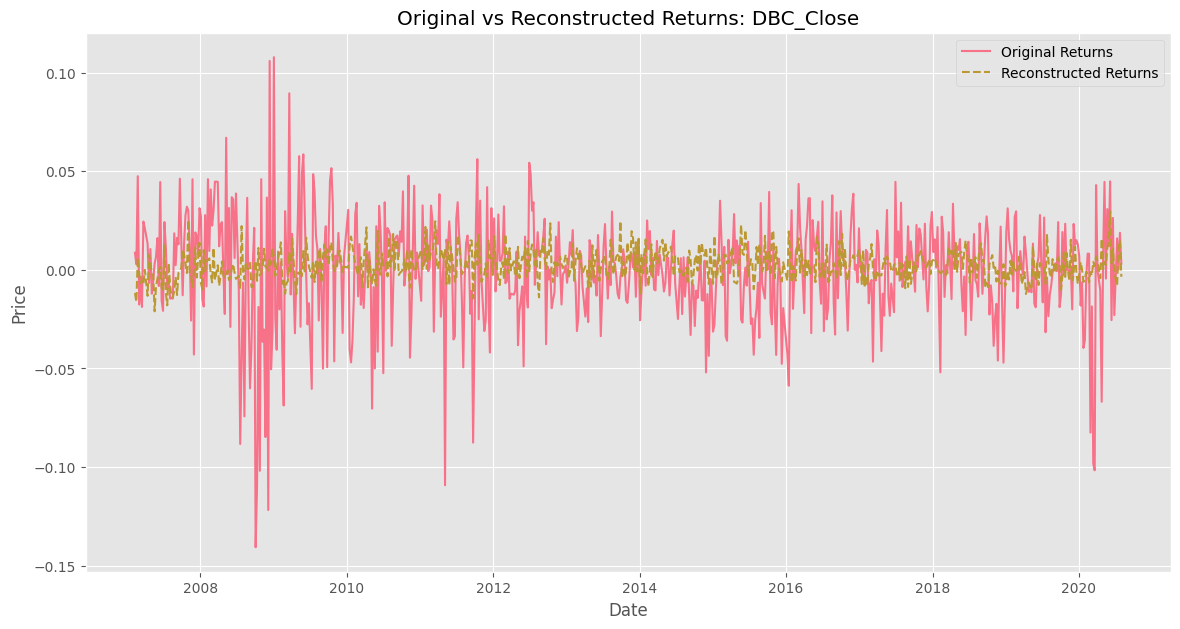

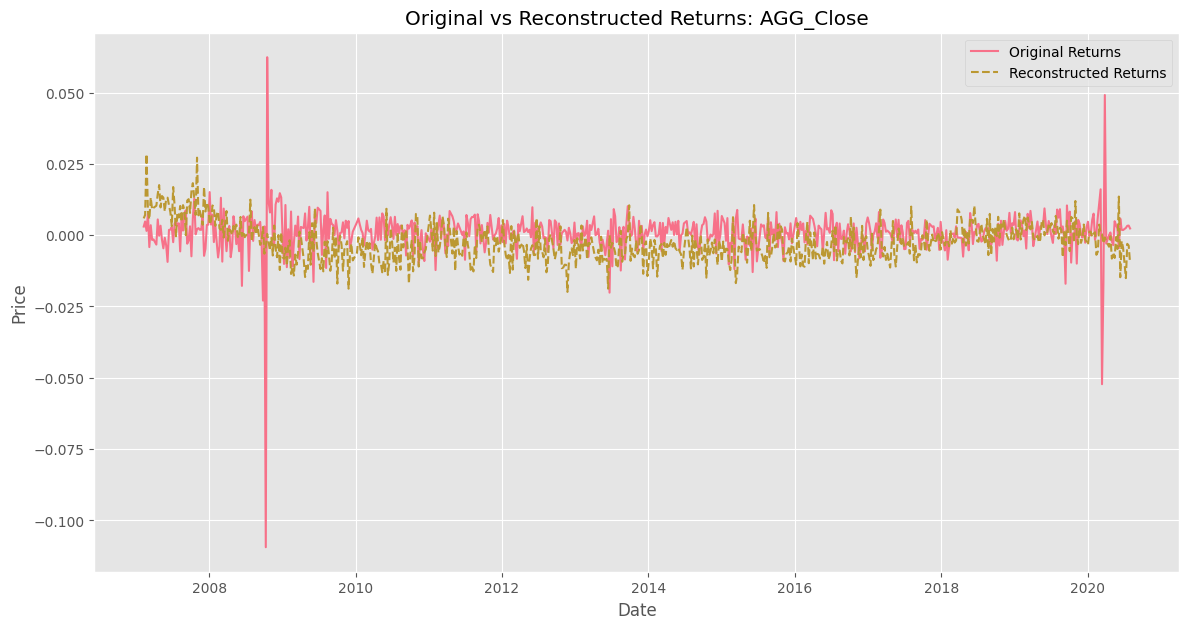

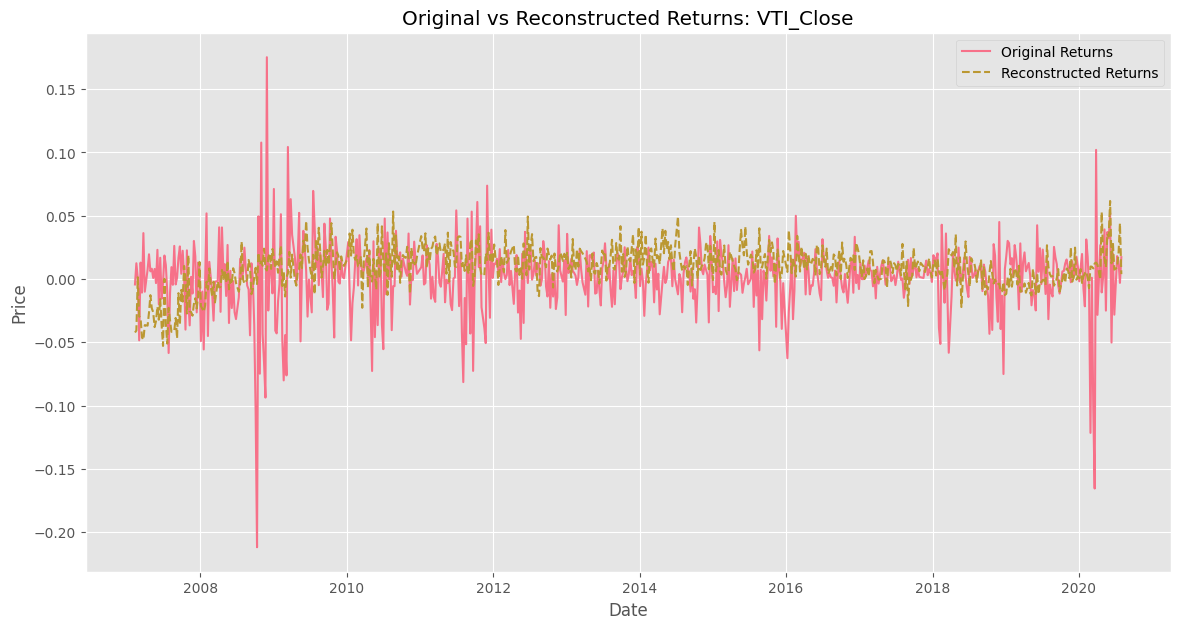

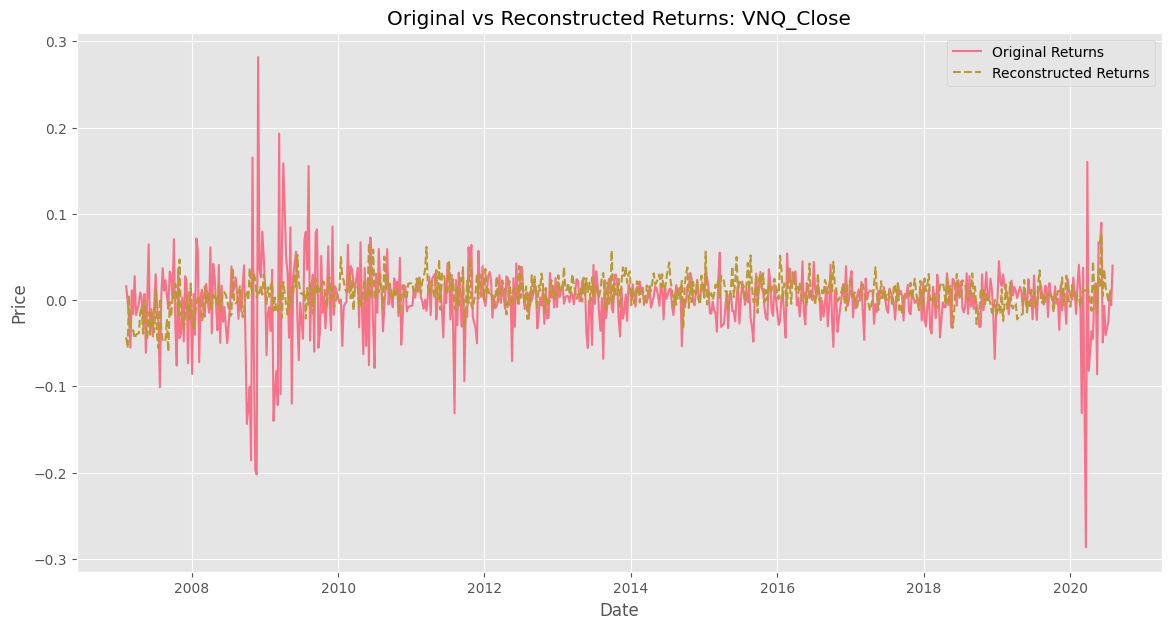

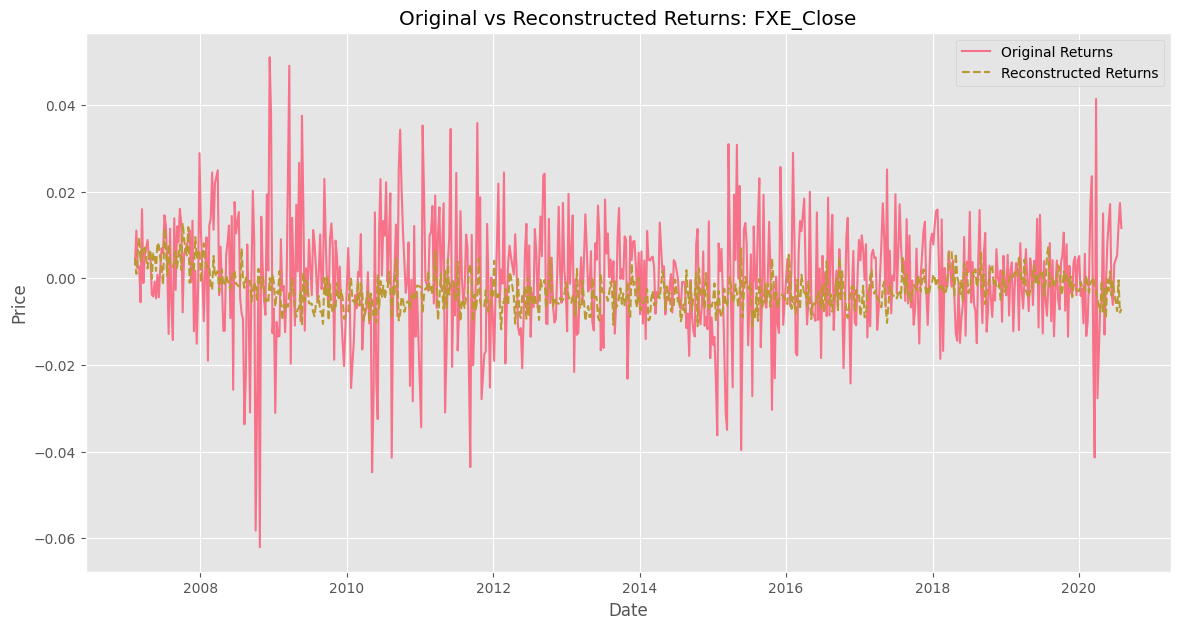

In [86]:
import pandas as pd
import matplotlib.pyplot as plt


# Step 1: Prepare the normalized data (already done in your previous steps)
# For this example, we'll assume `train_combined_df_normalized` and `train_df_interest_normalized` are ready

# Step 2: Use the model to reconstruct the data from the normalized train set
# Ensure your CVAE model has a suitable method for this, such as `reconstruct`
reconstructed, _, _ = cvae(returns_log.values, fedfunds.values)
reconstructed_prices = reconstructed.numpy()  # Adjust based on your model's output format

# Calculate the scaling factors only for the same 5 features
min_vals = history_train_clean.min()[returns_log.columns]  # Adjust this to match the specific columns
max_vals = history_train_clean.max()[returns_log.columns]  # Adjust this to match the specific columns

# Rescale the reconstructed prices using the appropriate min and max values
reconstructed_prices_rescaled = reconstructed_prices * (max_vals.values - min_vals.values) + min_vals.values
reconstructed_df = pd.DataFrame(reconstructed_prices_rescaled, columns=returns_log.columns, index=returns_log.index)
for ticker in returns_log.columns:
#ticker = 'VTI_Close'  # Example ticker, replace with an actual one from your dataset

  plt.figure(figsize=(14, 7))
  plt.plot(history_train_clean[ticker], label='Original Returns')
  plt.plot(reconstructed_df[ticker], label='Reconstructed Returns', linestyle='--')
  plt.title(f'Original vs Reconstructed Returns: {ticker}')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend()
  plt.show()



# Conditioning on credit spreads

In [97]:
ctrain_combined_df_normalized = (history_train_clean - history_train_clean.min()) / (history_train_clean.max() - history_train_clean.min())
returns_log = train_combined_df_normalized.iloc[:,:5]
credit_spreads = train_combined_df_normalized['credit_spreads']

train_dataseds = train_combined_df_normalized['credit_spreads']

train_dataset_cvae = tf.data.Dataset.from_tensor_slices((returns_log.values, credit_spreads.values))
train_dataset_cvae = train_dataset_cvae.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

print(train_dataset_cvae)
## Batching the dataset
batch_size = 8  # Adjust based on your requirements
train_dataset_cvae = train_dataset_cvae.batch(batch_size)



<_MapDataset element_spec=(TensorSpec(shape=(5,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [98]:
# Assuming combined_df and daily_interest are correctly prepared and normalized
latent_dim = 6
input_shape = returns_log.shape[1]  # Number of features in your ETF data

# Initialize CVAE model
cvae = CVAE(latent_dim=latent_dim, input_shape=input_shape)

# Training loop
epochs = 50
for epoch in range(epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    for x_batch, condition_batch in train_dataset_cvae:
        #print(x_batch)
        #print(condition_batch)
        loss = train_step(cvae, x_batch, condition_batch, optimizer)
        epoch_loss_avg.update_state(loss)
    print(f'Epoch: {epoch+1}, Loss: {epoch_loss_avg.result().numpy()}')


Epoch: 1, Loss: 0.20791256427764893
Epoch: 2, Loss: 0.04912066087126732
Epoch: 3, Loss: 0.028168553486466408
Epoch: 4, Loss: 0.026465052738785744
Epoch: 5, Loss: 0.02191963605582714
Epoch: 6, Loss: 0.019497593864798546
Epoch: 7, Loss: 0.020111260935664177
Epoch: 8, Loss: 0.01850164122879505
Epoch: 9, Loss: 0.01722598448395729
Epoch: 10, Loss: 0.016060492023825645
Epoch: 11, Loss: 0.015580996870994568
Epoch: 12, Loss: 0.01567899063229561
Epoch: 13, Loss: 0.0148871885612607
Epoch: 14, Loss: 0.014142666012048721
Epoch: 15, Loss: 0.013228115625679493
Epoch: 16, Loss: 0.01350199431180954
Epoch: 17, Loss: 0.012688710354268551
Epoch: 18, Loss: 0.013351061381399632
Epoch: 19, Loss: 0.012213089503347874
Epoch: 20, Loss: 0.011924614198505878
Epoch: 21, Loss: 0.011554187163710594
Epoch: 22, Loss: 0.011517026461660862
Epoch: 23, Loss: 0.011645974591374397
Epoch: 24, Loss: 0.010891664773225784
Epoch: 25, Loss: 0.0111917769536376
Epoch: 26, Loss: 0.010460302233695984
Epoch: 27, Loss: 0.0106160053983

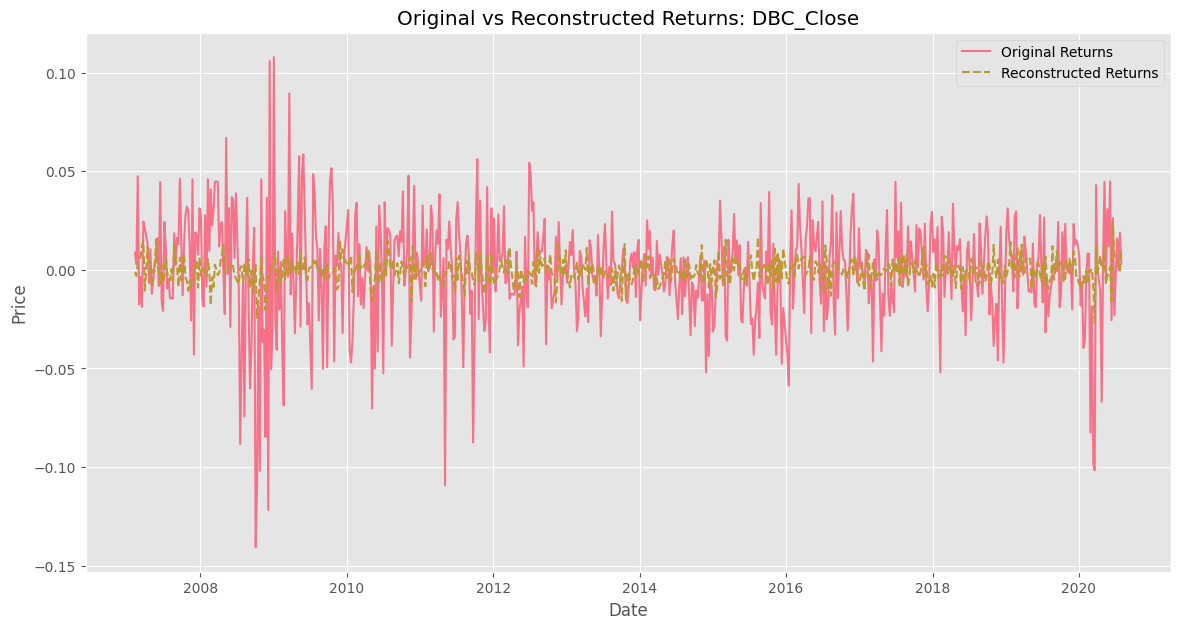

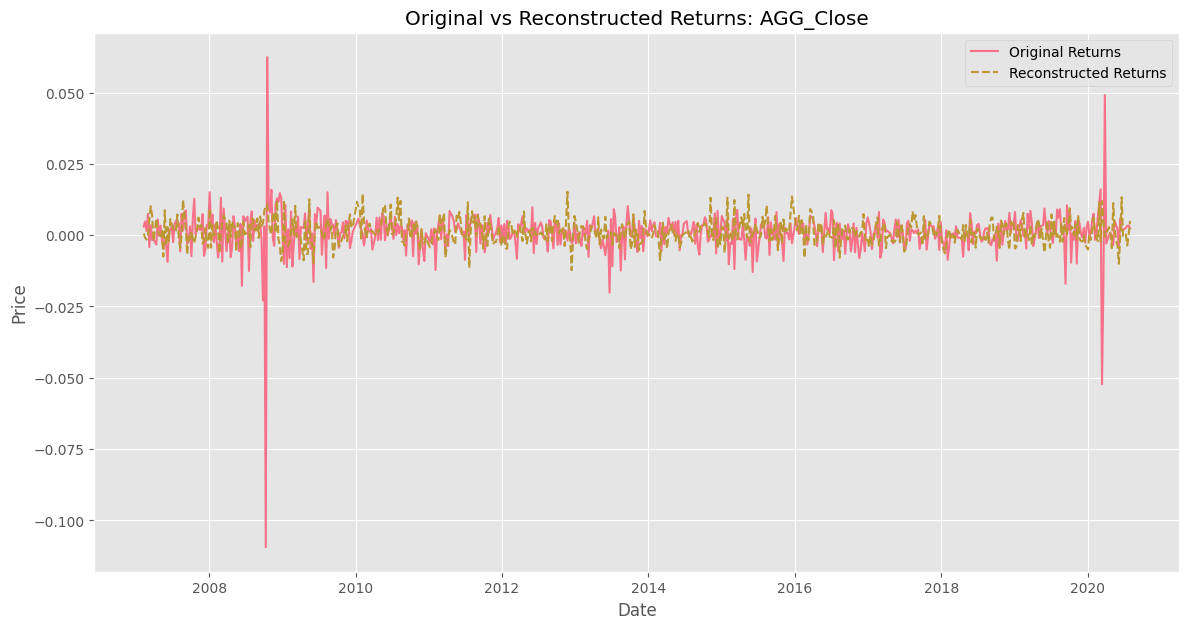

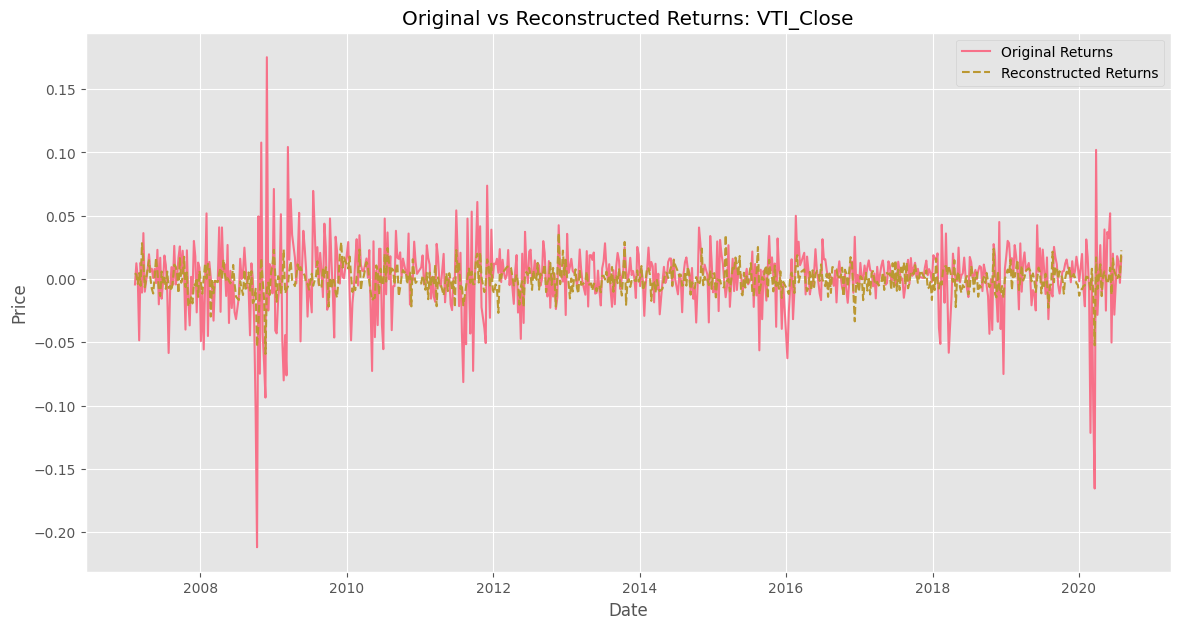

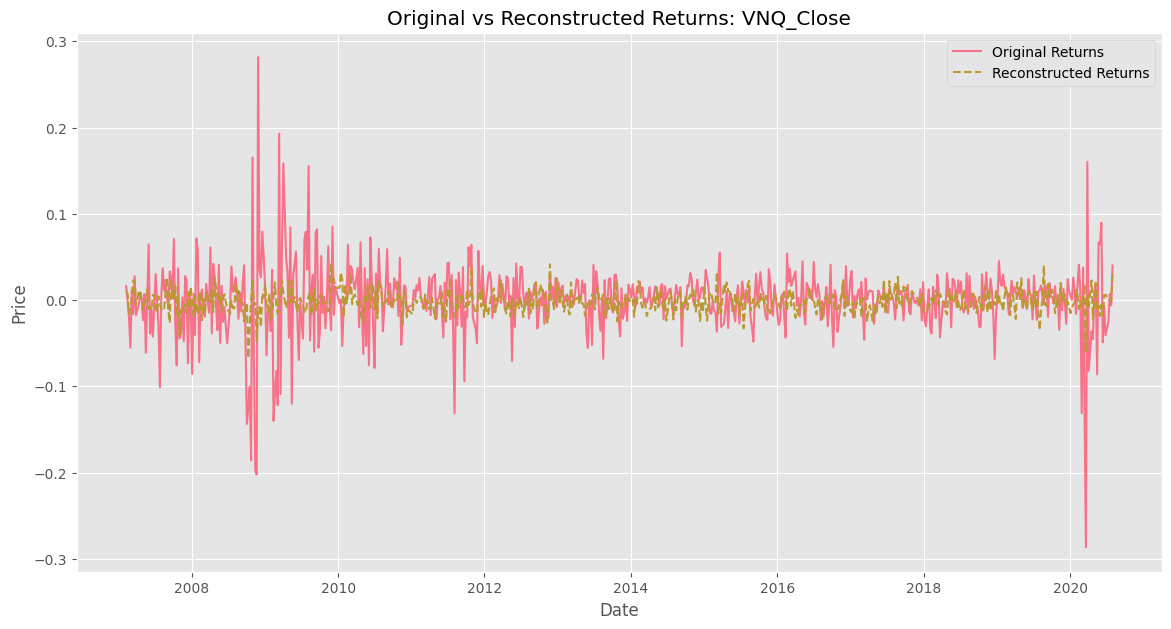

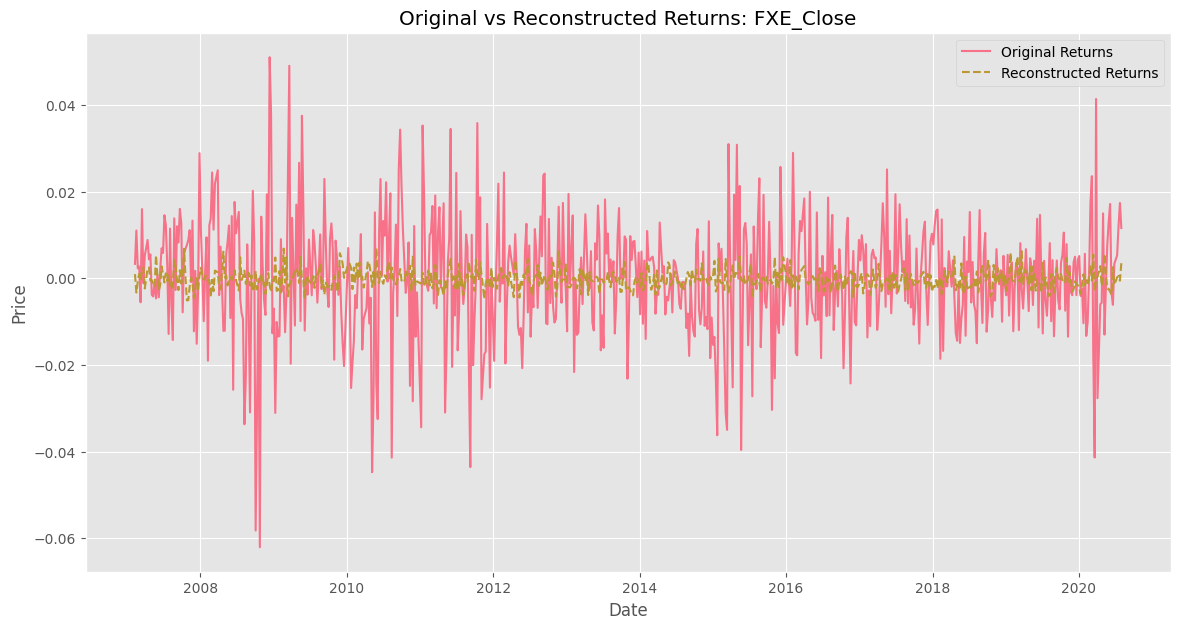

In [99]:
import pandas as pd
import matplotlib.pyplot as plt


# Step 1: Prepare the normalized data (already done in your previous steps)
# For this example, we'll assume `train_combined_df_normalized` and `train_df_interest_normalized` are ready

# Step 2: Use the model to reconstruct the data from the normalized train set
# Ensure your CVAE model has a suitable method for this, such as `reconstruct`
reconstructed, _, _ = cvae(returns_log.values, credit_spreads.values)
reconstructed_prices = reconstructed.numpy()  # Adjust based on your model's output format

# Calculate the scaling factors only for the same 5 features
min_vals = history_train_clean.min()[returns_log.columns]  # Adjust this to match the specific columns
max_vals = history_train_clean.max()[returns_log.columns]  # Adjust this to match the specific columns

# Rescale the reconstructed prices using the appropriate min and max values
reconstructed_prices_rescaled = reconstructed_prices * (max_vals.values - min_vals.values) + min_vals.values
reconstructed_df = pd.DataFrame(reconstructed_prices_rescaled, columns=returns_log.columns, index=returns_log.index)
for ticker in returns_log.columns:
#ticker = 'VTI_Close'  # Example ticker, replace with an actual one from your dataset

  plt.figure(figsize=(14, 7))
  plt.plot(history_train_clean[ticker], label='Original Returns')
  plt.plot(reconstructed_df[ticker], label='Reconstructed Returns', linestyle='--')
  plt.title(f'Original vs Reconstructed Returns: {ticker}')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend()
  plt.show()



# conditioning on fedfunds

In [92]:
train_combined_df_normalized = (history_train_clean - history_train_clean.min()) / (history_train_clean.max() - history_train_clean.min())
returns_log = train_combined_df_normalized.iloc[:,:5]
fedfunds = train_combined_df_normalized['fedfunds']

train_dataseds = train_combined_df_normalized['fedfunds']

train_dataset_cvae = tf.data.Dataset.from_tensor_slices((returns_log.values, fedfunds.values))
train_dataset_cvae = train_dataset_cvae.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))

print(train_dataset_cvae)
## Batching the dataset
batch_size = 8  # Adjust based on your requirements
train_dataset_cvae = train_dataset_cvae.batch(batch_size)



<_MapDataset element_spec=(TensorSpec(shape=(5,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [93]:
# Assuming combined_df and daily_interest are correctly prepared and normalized
latent_dim = 6
input_shape = returns_log.shape[1]  # Number of features in your ETF data

# Initialize CVAE model
cvae = CVAE(latent_dim=latent_dim, input_shape=input_shape)

# Training loop
epochs = 50
for epoch in range(epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    for x_batch, condition_batch in train_dataset_cvae:
        #print(x_batch)
        #print(condition_batch)
        loss = train_step(cvae, x_batch, condition_batch, optimizer)
        epoch_loss_avg.update_state(loss)
    print(f'Epoch: {epoch+1}, Loss: {epoch_loss_avg.result().numpy()}')


Epoch: 1, Loss: 0.2070775181055069
Epoch: 2, Loss: 0.05819355696439743
Epoch: 3, Loss: 0.03219170495867729
Epoch: 4, Loss: 0.026049599051475525
Epoch: 5, Loss: 0.0258248969912529
Epoch: 6, Loss: 0.023614410310983658
Epoch: 7, Loss: 0.02206902764737606
Epoch: 8, Loss: 0.019977757707238197
Epoch: 9, Loss: 0.018191728740930557
Epoch: 10, Loss: 0.01827823743224144
Epoch: 11, Loss: 0.017864476889371872
Epoch: 12, Loss: 0.016700373962521553
Epoch: 13, Loss: 0.01602190174162388
Epoch: 14, Loss: 0.015611113980412483
Epoch: 15, Loss: 0.014274301007390022
Epoch: 16, Loss: 0.013943715952336788
Epoch: 17, Loss: 0.012692689895629883
Epoch: 18, Loss: 0.012264734134078026
Epoch: 19, Loss: 0.012505711987614632
Epoch: 20, Loss: 0.011378058232367039
Epoch: 21, Loss: 0.011132538318634033
Epoch: 22, Loss: 0.010426286607980728
Epoch: 23, Loss: 0.010192587040364742
Epoch: 24, Loss: 0.010014355182647705
Epoch: 25, Loss: 0.009566661901772022
Epoch: 26, Loss: 0.009798415936529636
Epoch: 27, Loss: 0.00916188769

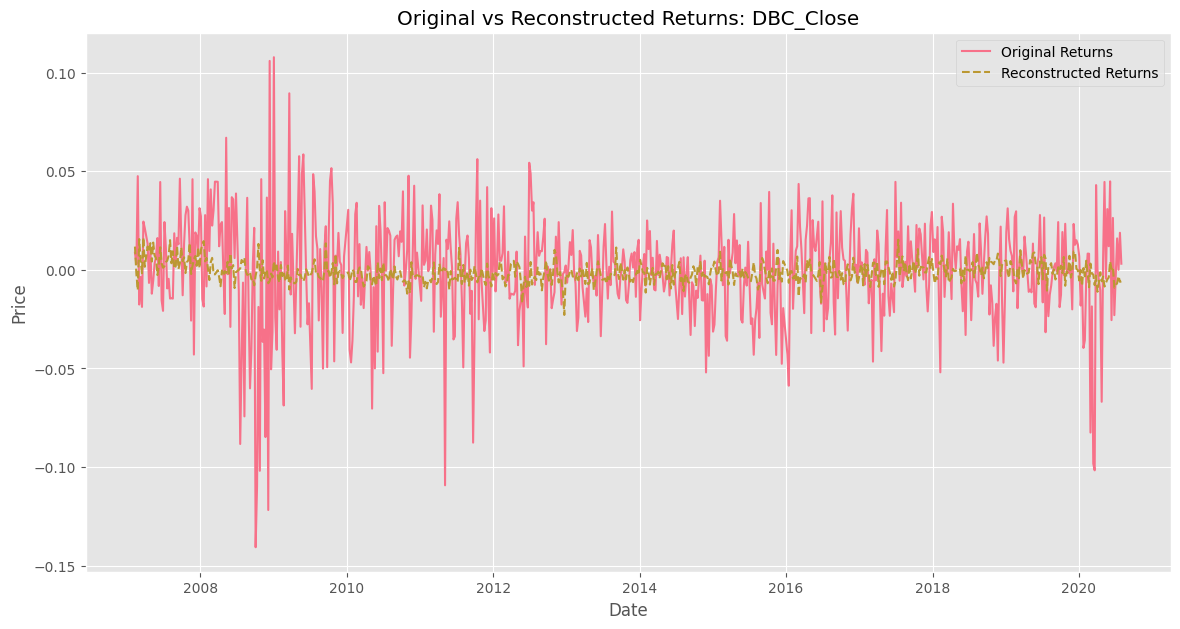

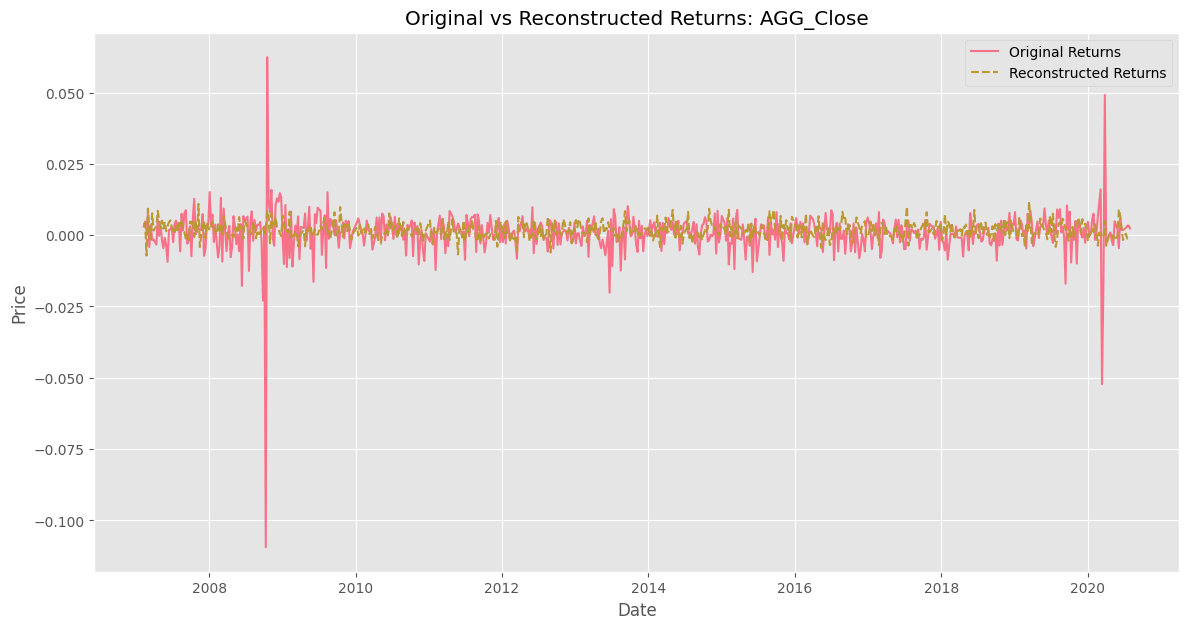

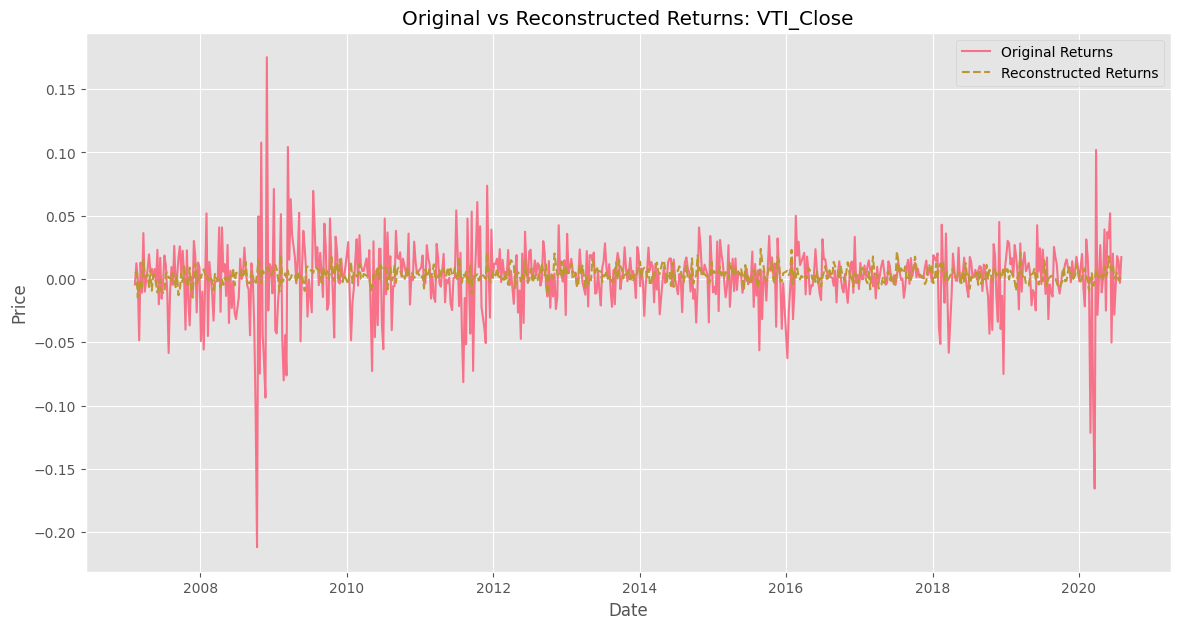

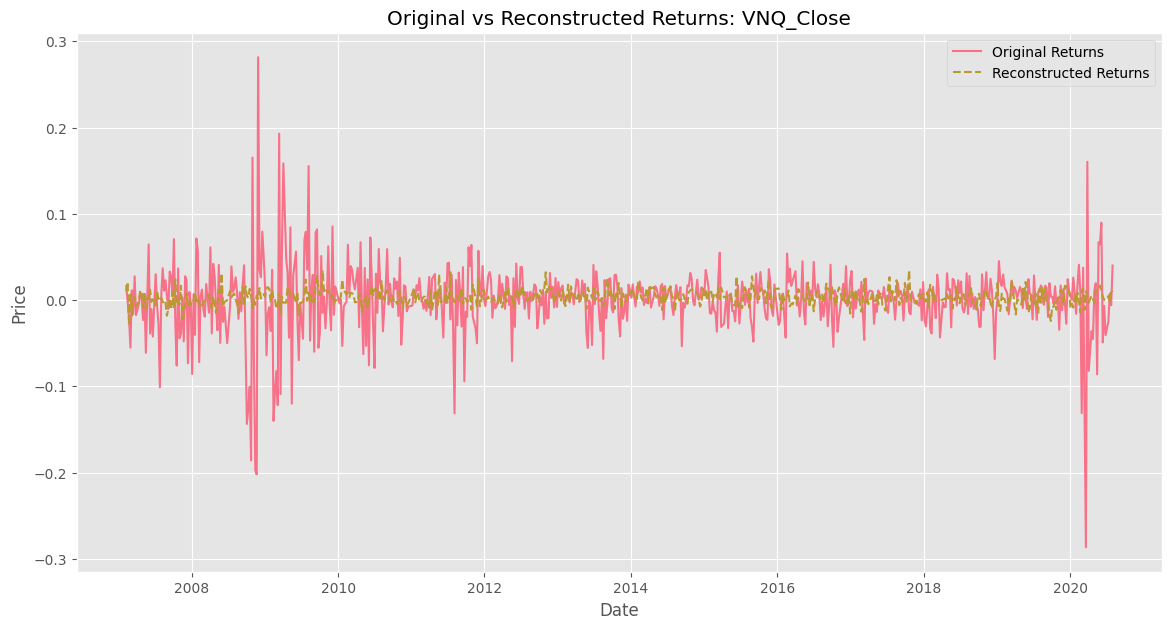

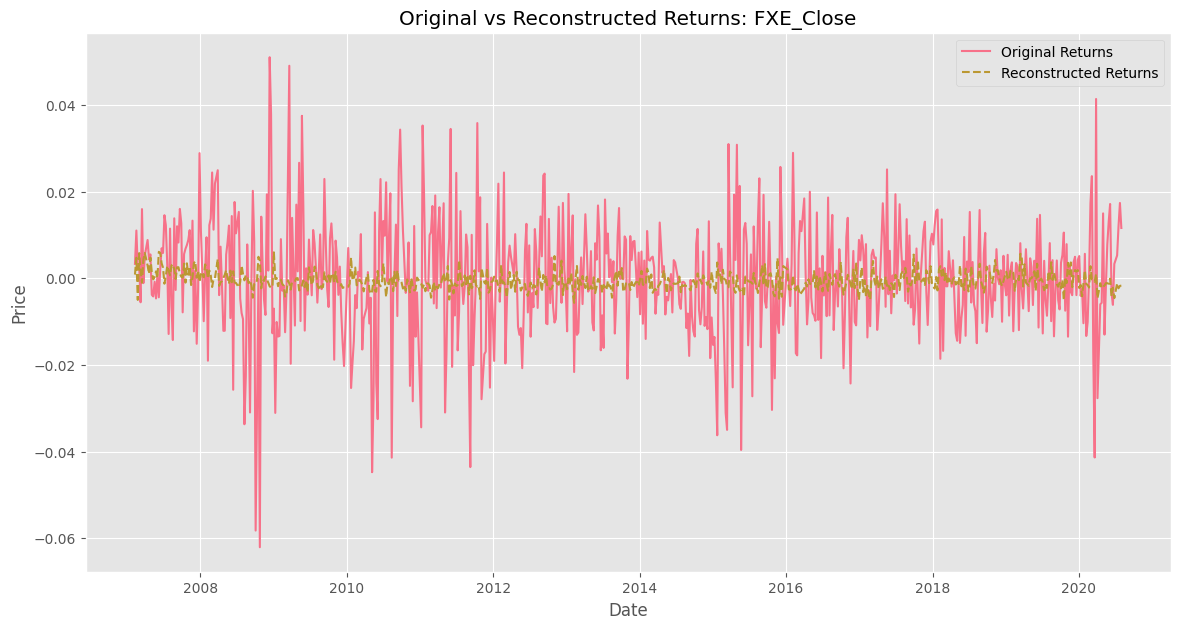

In [94]:
import pandas as pd
import matplotlib.pyplot as plt


# Step 1: Prepare the normalized data (already done in your previous steps)
# For this example, we'll assume `train_combined_df_normalized` and `train_df_interest_normalized` are ready

# Step 2: Use the model to reconstruct the data from the normalized train set
# Ensure your CVAE model has a suitable method for this, such as `reconstruct`
reconstructed, _, _ = cvae(returns_log.values, fedfunds.values)
reconstructed_prices = reconstructed.numpy()  # Adjust based on your model's output format

# Calculate the scaling factors only for the same 5 features
min_vals = history_train_clean.min()[returns_log.columns]  # Adjust this to match the specific columns
max_vals = history_train_clean.max()[returns_log.columns]  # Adjust this to match the specific columns

# Rescale the reconstructed prices using the appropriate min and max values
reconstructed_prices_rescaled = reconstructed_prices * (max_vals.values - min_vals.values) + min_vals.values
reconstructed_df = pd.DataFrame(reconstructed_prices_rescaled, columns=returns_log.columns, index=returns_log.index)
for ticker in returns_log.columns:
#ticker = 'VTI_Close'  # Example ticker, replace with an actual one from your dataset

  plt.figure(figsize=(14, 7))
  plt.plot(history_train_clean[ticker], label='Original Returns')
  plt.plot(reconstructed_df[ticker], label='Reconstructed Returns', linestyle='--')
  plt.title(f'Original vs Reconstructed Returns: {ticker}')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.legend()
  plt.show()

